In [ ]:
!unzip /content/acne_plus_2.zip

Archive:  /content/acne_plus_2.zip
   creating: acne_plus_2/
   creating: acne_plus_2/acne/
   creating: acne_plus_2/acne/test/
   creating: acne_plus_2/acne/test/blackhead/
  inflating: acne_plus_2/acne/test/blackhead/b61.jpg  
  inflating: acne_plus_2/acne/test/blackhead/b62.jfif  
  inflating: acne_plus_2/acne/test/blackhead/b63.jpg  
  inflating: acne_plus_2/acne/test/blackhead/b64.jpg  
  inflating: acne_plus_2/acne/test/blackhead/b65.jpg  
  inflating: acne_plus_2/acne/test/blackhead/b66.jpg  
  inflating: acne_plus_2/acne/test/blackhead/b67.jpg  
  inflating: acne_plus_2/acne/test/blackhead/b68.jpg  
  inflating: acne_plus_2/acne/test/blackhead/b69.jpg  
  inflating: acne_plus_2/acne/test/blackhead/b70.jpg  
   creating: acne_plus_2/acne/test/nodules/
  inflating: acne_plus_2/acne/test/nodules/n37.JPG  
  inflating: acne_plus_2/acne/test/nodules/n42.JPG  
  inflating: acne_plus_2/acne/test/nodules/n62.JPG  
  inflating: acne_plus_2/acne/test/nodules/n63.JPG  
  inflating: acne_p

In [ ]:
import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2, NASNetMobile, ResNet50V2, EfficientNetB0, DenseNet121
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import Input, MaxPool2D
import numpy as np
import matplotlib.pyplot as plt
import pathlib
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

In [ ]:
TRAINING_DIR = "acne_plus_2/acne/train"
VALIDATION_DIR = "acne_plus_2/acne/test"

train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    fill_mode='nearest'
)

train_generator = train_datagen.flow_from_directory(TRAINING_DIR,
                                                    class_mode='categorical',
                                                    target_size=(224, 224))

validation_datagen = ImageDataGenerator(
    rescale=1.0/255
)
validation_generator = validation_datagen.flow_from_directory(VALIDATION_DIR,
                                                        class_mode='categorical',
                                                        target_size=(224, 224))

Found 306 images belonging to 5 classes.
Found 54 images belonging to 5 classes.


In [ ]:
print(train_generator.class_indices)

{'blackhead': 0, 'nodules': 1, 'normalface': 2, 'papula': 3, 'pustula': 4}


In [ ]:
# Pretrain Model
pre_trained_model = ResNet50V2(input_shape=(224, 224, 3), include_top=False, weights='imagenet')

for layer in pre_trained_model.layers:
    layer.trainable = False

94668760/94668760 [==============================] - 1s 0us/step


In [ ]:
model = tf.keras.Sequential([
    pre_trained_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(5, activation='softmax')
])

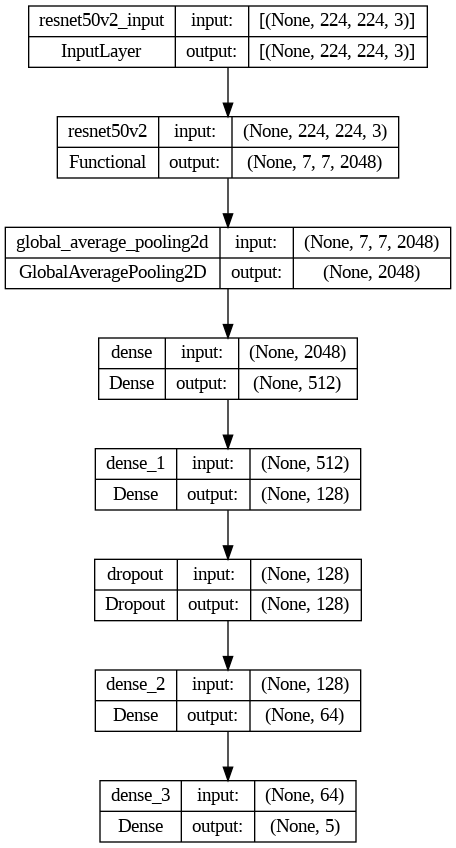

In [ ]:
from tensorflow.keras.utils import plot_model

# visualisasi model
plot_model(model, to_file='model.png', show_shapes=True)

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 7, 7, 2048)        23564800  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 512)               1049088   
                                                                 
 dense_1 (Dense)             (None, 128)               65664     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                        

In [ ]:
int_lr = 0.0001
num_epochs = 100

# Early Stopping
earlystop_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

# Model Checkpoint
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='best_weights.h5',
    monitor='val_accuracy',
    save_best_only=True,
    save_weights_only=True,
    verbose=1
)

# Compile and Training
optimizer = tf.optimizers.Adam(learning_rate=int_lr)
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.fit(
    train_generator,
    epochs=num_epochs,
    validation_data=validation_generator,
    callbacks=[earlystop_callback, checkpoint_callback]
)

Epoch 1/100
10/10 [==============================] - ETA: 0s - loss: 1.5522 - accuracy: 0.3137
Epoch 1: val_accuracy improved from -inf to 0.46296, saving model to best_weights.h5
10/10 [==============================] - 42s 4s/step - loss: 1.5522 - accuracy: 0.3137 - val_loss: 1.2598 - val_accuracy: 0.4630
Epoch 2/100
10/10 [==============================] - ETA: 0s - loss: 1.2232 - accuracy: 0.5327
Epoch 2: val_accuracy improved from 0.46296 to 0.64815, saving model to best_weights.h5
10/10 [==============================] - 37s 4s/step - loss: 1.2232 - accuracy: 0.5327 - val_loss: 1.0259 - val_accuracy: 0.6481
Epoch 3/100
10/10 [==============================] - ETA: 0s - loss: 1.0486 - accuracy: 0.5654
Epoch 3: val_accuracy improved from 0.64815 to 0.75926, saving model to best_weights.h5
10/10 [==============================] - 41s 4s/step - loss: 1.0486 - accuracy: 0.5654 - val_loss: 0.8538 - val_accuracy: 0.7593
Epoch 4/100
10/10 [==============================] - ETA: 0s - loss

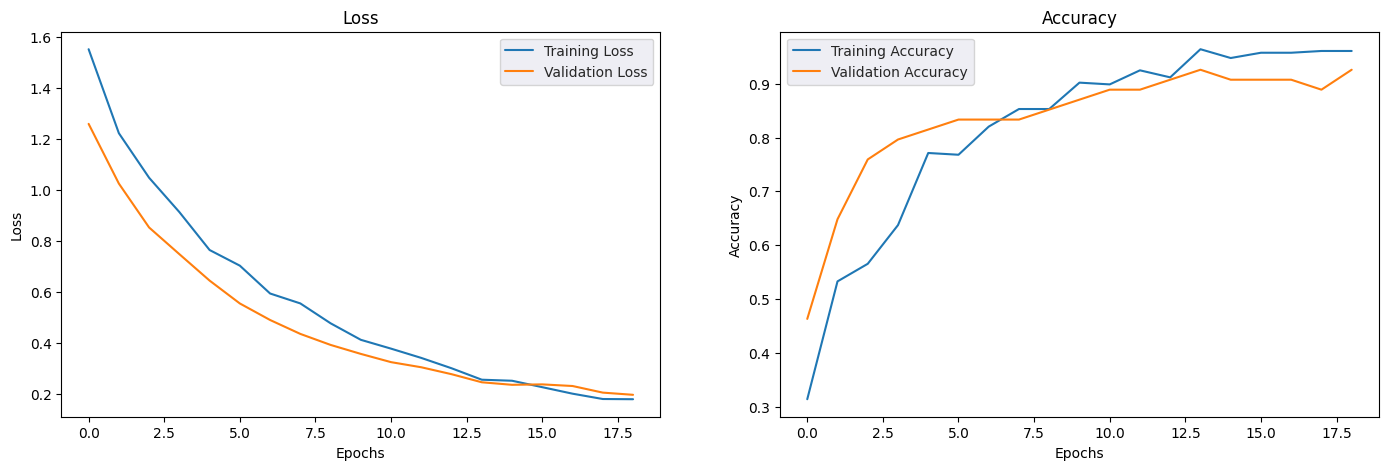

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Membuat list nilai loss dan akurasi dari model
train_loss = model.history.history['loss']
val_loss = model.history.history['val_loss']
train_acc = model.history.history['accuracy']
val_acc = model.history.history['val_accuracy']

# Membuat plot
fig, ax = plt.subplots(1,2, figsize=(17,5))
sns.set_style("darkgrid")

# Plot loss
ax[0].plot(train_loss, label='Training Loss')
ax[0].plot(val_loss, label='Validation Loss')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].set_title('Loss')
ax[0].legend()

# Plot accuracy
ax[1].plot(train_acc, label='Training Accuracy')
ax[1].plot(val_acc, label='Validation Accuracy')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy')
ax[1].set_title('Accuracy')
ax[1].legend()

plt.show()

In [ ]:
# Load weights
model.load_weights('best_weights.h5')

# Evaluate model on validation set
loss, accuracy = model.evaluate(validation_generator, verbose=1)
print('Validation Accuracy: {:.2%}'.format(accuracy))
print('Validation Loss: {:.2f}'.format(loss))

2/2 [==============================] - 6s 3s/step - loss: 0.2474 - accuracy: 0.9259
Validation Accuracy: 92.59%
Validation Loss: 0.25


In [ ]:
# Mendapatkan label yang sesuai dengan prediksi
class_labels = validation_generator.class_indices
class_labels = {v: k for k, v in class_labels.items()}

In [ ]:
# Memuat bobot terbaik yang disimpan selama pelatihan
model.load_weights('best_weights.h5')

# Mengumpulkan semua prediksi dan label asli
y_pred = []
labels = []
for i in range(len(validation_generator)):
    batch_data, batch_labels = validation_generator[i]
    batch_pred = model.predict(batch_data)
    y_pred.extend(np.argmax(batch_pred, axis=1))
    labels.extend(np.argmax(batch_labels, axis=1))

1/1 [==============================] - 3s 3s/step


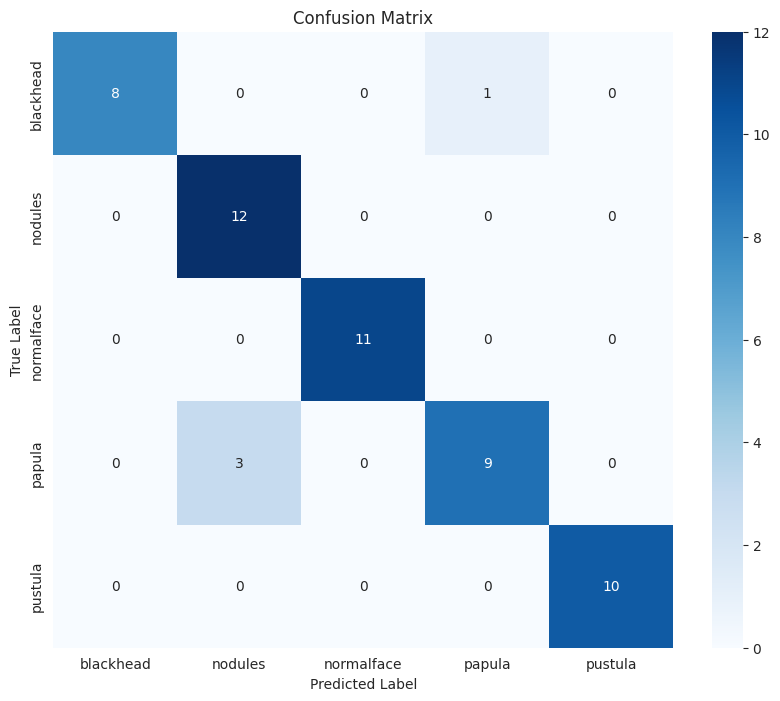

Classification Report:
              precision    recall  f1-score   support

   blackhead       1.00      0.89      0.94         9
     nodules       0.80      1.00      0.89        12
  normalface       1.00      1.00      1.00        11
      papula       0.90      0.75      0.82        12
     pustula       1.00      1.00      1.00        10

    accuracy                           0.93        54
   macro avg       0.94      0.93      0.93        54
weighted avg       0.93      0.93      0.93        54



In [ ]:
# Menghitung matriks kebingungan
cm = confusion_matrix(labels, y_pred)

# Menghitung akurasi
accuracy = np.sum(labels == y_pred) / len(labels)

# Membuat plot matriks kebingungan
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels.values(), yticklabels=class_labels.values())
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Mencetak laporan klasifikasi
classification_report_str = classification_report(labels, y_pred, target_names=class_labels.values())
print("Classification Report:")
print(classification_report_str)

In [ ]:
export_dir = 'saved_model/'
tf.saved_model.save(model, export_dir)

# Convert SavedModel menjadi .tflite
converter = tf.lite.TFLiteConverter.from_saved_model(export_dir)
tflite_model = converter.convert()

tflite_model_file = pathlib.Path('92_resnet.tflite')
tflite_model_file.write_bytes(tflite_model)

98595136